<a href="https://colab.research.google.com/github/SunbirdAI/lamwo-electrification-project/blob/main/notebooks/predicting_minigrid_villages/train_electrification_strategy_for_village_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

Import required modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report


## 1. Data Loading and Preprocessing

Load extracted/preprocessed data from feature selection. Combine the two minigrid classes into 1 since we mainly want to predict whether a village is viable for minigrid installation.

In [2]:
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)

    # Combine minigrid classes
    df['electrification_strategy'] = df['electrification_strategy'].replace({
        'Candidate minigrid': 'minigrid',
        'Existing minigrid': 'minigrid'
    })

    # Features to exclude
    exclude_features = ['village_id', 'candidate_minigrids', 'existing_minigrids', 'protected_area_name']

    # Separate features and target
    X = df.drop(columns=exclude_features + ['electrification_strategy'])
    y = df['electrification_strategy']

    # Handle categorical variables
    X['contains_protected_area'] = X['contains_protected_area'].astype(int)

    # Handle missing values
    X = X.fillna(0)

    return X, y

## 2. Define Model Training and Evaluation

In [3]:
def train_and_evaluate_models(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    # Simple model: Logistic Regression
    log_reg = LogisticRegression(max_iter=1000, random_state=42)

    # Complex model: Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

    models = {
        'Logistic Regression': log_reg,
        'Random Forest': rf_clf
    }

    results = {}

    # Train and evaluate each model
    for name, model in models.items():
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

        # Fit the model
        model.fit(X_train_scaled, y_train)

        # Predictions and probabilities
        y_pred = model.predict(X_test_scaled)
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test_scaled)

        # Store results
        results[name] = {
            'model': model,
            'cv_scores': cv_scores,
            'y_pred': y_pred,
            'y_test': y_test
        }

        print(f"\n{name}:")
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

    return results, X_train_scaled, X_test_scaled, y_train, y_test, scaler

## 3. Visualization

In [4]:
def plot_results(results, X, y):
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    for idx, (name, result) in enumerate(results.items()):
        # Confusion Matrix
        cm = confusion_matrix(result['y_test'], result['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx, 0])
        axes[idx, 0].set_title(f'Confusion Matrix - {name}')
        axes[idx, 0].set_xlabel('Predicted')
        axes[idx, 0].set_ylabel('Actual')

        # Feature Importance (if available)
        if name == 'Random Forest':
            importances = result['model'].feature_importances_
            indices = np.argsort(importances)[::-1]

            axes[idx, 1].bar(range(X.shape[1]), importances[indices])
            axes[idx, 1].set_title(f'Feature Importance - {name}')
            axes[idx, 1].set_xticks(range(X.shape[1]))
            axes[idx, 1].set_xticklabels(X.columns[indices], rotation=90)

    plt.tight_layout()
    plt.show()

## 4. Feature Importance Analysis

In [5]:
def analyze_feature_importance(results, X):
    for name, result in results.items():
        if name == 'Random Forest':
            print(f"\nFeature Importance for {name}:")
            importances = result['model'].feature_importances_
            feature_imp = pd.DataFrame({
                'feature': X.columns,
                'importance': importances
            }).sort_values('importance', ascending=False)
            print(feature_imp)

        elif name == 'Logistic Regression':
            print(f"\nFeature Coefficients for {name}:")
            coefficients = pd.DataFrame({
                'feature': X.columns,
                'coefficient': np.abs(result['model'].coef_[0])
            }).sort_values('coefficient', ascending=False)
            print(coefficients)

## 5. Save Models Function (to be used after training)

In [6]:
def save_models(log_reg, rf, scaler, feature_names, base_path='models/'):
    """Save trained models and scaler"""
    pickle.dump(log_reg, open(f'{base_path}log_reg_model.pkl', 'wb'))
    pickle.dump(rf, open(f'{base_path}rf_model.pkl', 'wb'))
    pickle.dump(scaler, open(f'{base_path}scaler.pkl', 'wb'))
    with open(f'{base_path}feature_names.txt', 'w') as f:
        f.write(','.join(feature_names))

## Main: Train and evaluate models

Load village data from `./data/processed/`

In [7]:
file_path = 'village_data.csv'
X, y = load_and_preprocess_data(file_path)

In [9]:
X.head()

,facilities,grid_extension,existing_grid,mean_ndvi,mean_wind_speed,mean_pvout_solar_radiation,building_count,permanent_building_count,educational_facilities,health_facilities,social_facilities,services,primary_roads,secondary_roads,tertiary_roads,unclassified_roads,percentage_crop_land,percentage_built_area,contains_protected_area
0,0,0,0,0.000000,0.000000,0.000000,7,0,0,0,0,0,0,0,0,0,20.356667,1.140000,0
1,1,0,0,0.000000,0.000000,1563.144571,17,3,0,1,0,0,0,0,0,1,3.387500,0.026667,1
2,0,0,0,0.000000,0.000000,1561.565267,99,5,0,0,0,0,0,0,0,0,16.712500,3.160000,1
3,0,0,0,0.300514,0.895073,1587.815039,101,4,0,0,0,0,0,0,0,0,24.385000,2.506667,1
4,0,0,0,0.000000,0.000000,1618.240479,0,0,0,0,0,0,0,0,0,0,20.292500,0.015000,1


In [10]:
y.head()

,electrification_strategy
0,Solar home system
1,Solar home system
2,Solar home system
3,Solar home system
4,Solar home system


Train and evaluate models

In [11]:
results, X_train_scaled, X_test_scaled, y_train, y_test, scaler = train_and_evaluate_models(X, y)


Logistic Regression:
Cross-validation scores: [0.84848485 0.84848485 0.86363636 0.81538462 0.87692308]
Mean CV accuracy: 0.851 (+/- 0.041)

Classification Report:
                   precision    recall  f1-score   support

    Existing grid       1.00      1.00      1.00         8
   Grid extension       1.00      1.00      1.00        13
Solar home system       0.86      0.96      0.91        51
         minigrid       0.60      0.27      0.38        11

         accuracy                           0.88        83
        macro avg       0.86      0.81      0.82        83
     weighted avg       0.86      0.88      0.86        83


Random Forest:
Cross-validation scores: [0.78787879 0.90909091 0.84848485 0.76923077 0.90769231]
Mean CV accuracy: 0.844 (+/- 0.117)

Classification Report:
                   precision    recall  f1-score   support

    Existing grid       1.00      1.00      1.00         8
   Grid extension       1.00      1.00      1.00        13
Solar home system       0

Plot results

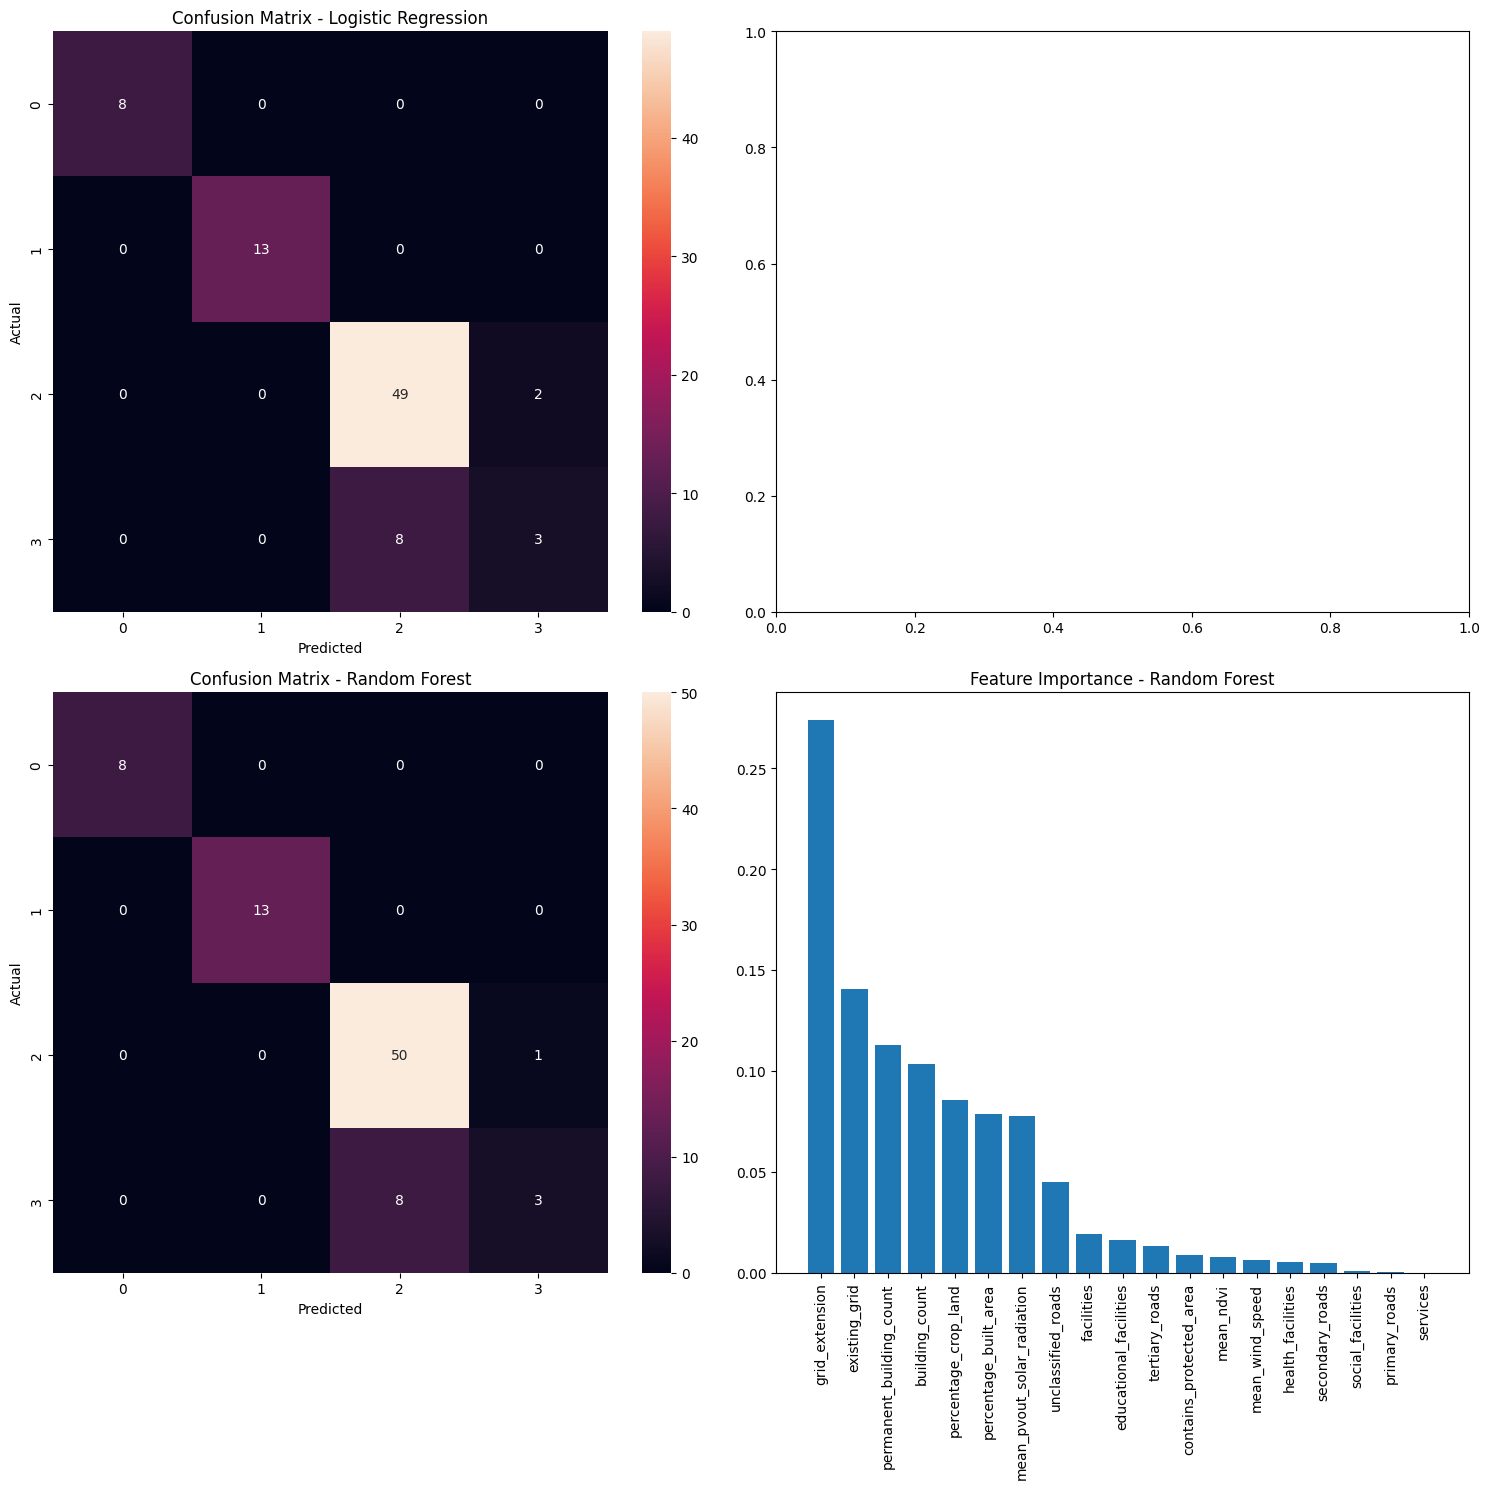

In [12]:
plot_results(results, X, y)

Analyze feature importance

In [13]:
analyze_feature_importance(results, X)



Feature Coefficients for Logistic Regression:
                       feature  coefficient
2                existing_grid     1.909132
1               grid_extension     0.655868
7     permanent_building_count     0.142850
10           social_facilities     0.103724
14              tertiary_roads     0.082672
6               building_count     0.082037
8       educational_facilities     0.081890
5   mean_pvout_solar_radiation     0.067272
0                   facilities     0.063292
12               primary_roads     0.056381
17       percentage_built_area     0.051272
15          unclassified_roads     0.040431
3                    mean_ndvi     0.031302
9            health_facilities     0.030745
4              mean_wind_speed     0.021131
13             secondary_roads     0.016162
18     contains_protected_area     0.006832
16        percentage_crop_land     0.004592
11                    services     0.000000

Feature Importance for Random Forest:
                       feature  im

Save models

In [14]:
!mkdir models

In [15]:
save_models(
    results['Logistic Regression']['model'],
    results['Random Forest']['model'],
    scaler,
    X.columns.tolist()
)

In [16]:
!zip -r electrification_strategy_models.zip models

  adding: models/ (stored 0%)
  adding: models/rf_model.pkl (deflated 83%)
  adding: models/feature_names.txt (deflated 49%)
  adding: models/log_reg_model.pkl (deflated 15%)
  adding: models/scaler.pkl (deflated 25%)
